In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import math
import data_loader
from torch.utils import model_zoo
from sklearn.manifold import TSNE
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import mmd
import torch


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.baselayer = [self.conv1, self.bn1, self.layer1, self.layer2, self.layer3, self.layer4]
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        #self.mmd = nn.Linear(512 * block.expansion, 512)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)

        return x

class myDDC(nn.Module):

    def __init__(self, num_classes=31):
        super(myDDC, self).__init__()
        self.sharedNet = resnet50(True)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.feature_layers = nn.Sequential(self.sharedNet, self.avgpool)

        self.bottle = nn.Linear(2048, 256)
        self.cls_fc = nn.Linear(256, num_classes)


    def forward(self, source):
        source = self.feature_layers(source)
        source = source.view(source.size(0), -1)
        source = self.bottle(source)

        return source
    
    
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

In [3]:


#torch.manual_seed(args.seed)
#if args.cuda:
#    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True}

root_path = "/data/zhuyc/OFFICE31/"
source_dir = "amazon"
test_dir = "webcam"

def load_data():
    source_test_loader = data_loader.load_testing(root_path, source_dir, 32, kwargs)
    target_test_loader = data_loader.load_testing(root_path, test_dir, 32, kwargs)

    return source_test_loader, target_test_loader

def test(model, test_loader):
    model.eval()

    feature = None
    label = None
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        s_output = model(data)
        if feature is None:
            feature = s_output.cpu().data.numpy()
            label = target.cpu().data.numpy()
        else:
            print(label.shape, target.cpu().data.numpy().shape)
            feature = np.vstack((feature,s_output.cpu().data.numpy()))
            label = np.concatenate((label, target.cpu().data.numpy()))
        
    return feature, label


if __name__ == '__main__':
    model = myDDC(num_classes=31)
    pre_model = torch.load('model.pkl')
    torch.save(pre_model.state_dict(), 'dict_model.pth')
    model.load_state_dict(torch.load('dict_model.pth'))
    print(model)
    model.cuda()
    train_loader, test_loader = load_data()
    print("model add successful")

myDDC(
  (sharedNet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2

In [4]:
    source_only_emb, source_labels = test(model, train_loader)
    print(source_only_emb.shape, source_labels.shape)
    
    target_only_emb, target_labels = test(model, test_loader)
    print(target_only_emb.shape, target_labels.shape)

/home/zhuyc/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


(32,) (32,)
(64,) (32,)
(96,) (32,)
(128,) (32,)
(160,) (32,)
(192,) (32,)
(224,) (32,)
(256,) (32,)
(288,) (32,)
(320,) (32,)
(352,) (32,)
(384,) (32,)
(416,) (32,)
(448,) (32,)
(480,) (32,)
(512,) (32,)
(544,) (32,)
(576,) (32,)
(608,) (32,)
(640,) (32,)
(672,) (32,)
(704,) (32,)
(736,) (32,)
(768,) (32,)
(800,) (32,)
(832,) (32,)
(864,) (32,)
(896,) (32,)
(928,) (32,)
(960,) (32,)
(992,) (32,)
(1024,) (32,)
(1056,) (32,)
(1088,) (32,)
(1120,) (32,)
(1152,) (32,)
(1184,) (32,)
(1216,) (32,)
(1248,) (32,)
(1280,) (32,)
(1312,) (32,)
(1344,) (32,)
(1376,) (32,)
(1408,) (32,)
(1440,) (32,)
(1472,) (32,)
(1504,) (32,)
(1536,) (32,)
(1568,) (32,)
(1600,) (32,)
(1632,) (32,)
(1664,) (32,)
(1696,) (32,)
(1728,) (32,)
(1760,) (32,)
(1792,) (32,)
(1824,) (32,)
(1856,) (32,)
(1888,) (32,)
(1920,) (32,)
(1952,) (32,)
(1984,) (32,)
(2016,) (32,)
(2048,) (32,)
(2080,) (32,)
(2112,) (32,)
(2144,) (32,)
(2176,) (32,)
(2208,) (32,)
(2240,) (32,)
(2272,) (32,)
(2304,) (32,)
(2336,) (32,)
(2368,) (32,

In [5]:
    total_feature = np.vstack((source_only_emb, target_only_emb))
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    total_only_tsne = tsne.fit_transform(total_feature)
    source_only_tsne = total_only_tsne[:2817,:]
    target_only_tsne = total_only_tsne[2817:,:]
    dlabel = np.zeros(2817+795)
    dlabel[:2817] = 1
    #source_only_tsne = tsne.fit_transform(source_only_emb)

[1. 1. 1. ... 0. 0. 0.]


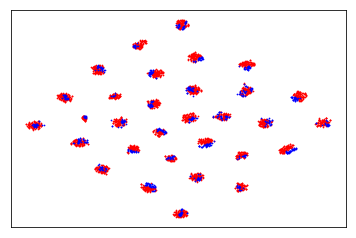

In [9]:
    import matplotlib.pyplot as plt
    print(dlabel)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(source_only_tsne[:,0], source_only_tsne[:,1], c='red', s=0.5, marker='o')
    plt.scatter(target_only_tsne[:,0], target_only_tsne[:,1], c='blue', s=0.5, marker='o')
    plt.savefig('DSAN_AtoW.pdf',format='pdf',dpi=1000)
    #plot_embedding(source_only_tsne, source_labels, 'Source')

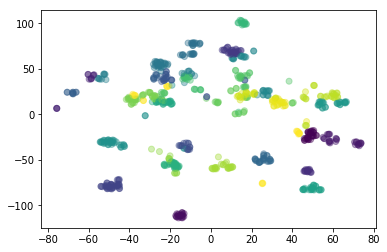

In [12]:
    #tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    #target_only_tsne = tsne.fit_transform(target_only_emb)
    plt.scatter(target_only_tsne[:,0], target_only_tsne[:,1], c=target_labels, alpha=0.4)
    #plot_embedding(target_only_tsne, target_labels, 'Target')

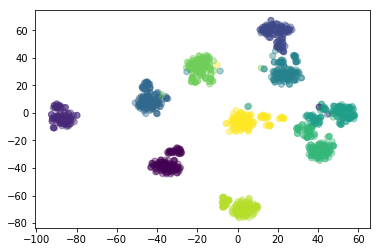

In [9]:
    plt.scatter(source_only_tsne[:,0], source_only_tsne[:,1], c=source_labels, alpha=0.4)
    plt.scatter(target_only_tsne[:,0], target_only_tsne[:,1], c=target_labels, alpha=0.4)

In [5]:
    from sklearn import svm  
    from sklearn import linear_model
    sn = source_labels.shape
    tn = target_labels.shape
    print(sn, tn)
    source_domain = np.zeros(sn)
    target_domain = np.ones(tn)
    domain_label = np.concatenate((source_domain, target_domain))
    feature = np.vstack((source_only_emb, target_only_emb))
    clf = svm.SVC(kernel='linear')# linear_model.LinearRegression()  # class   svm.SVC(kernel='linear')
    clf.fit(feature, domain_label)  # training the svc model 
    result = clf.predict(feature)
    #print(result)
    


(958,) (295,)


In [6]:
    from sklearn.metrics import accuracy_score
    clf.score(feature, domain_label)
    #accuracy_score(domain_label, result)

0.9058260175578612

In [7]:
    from sklearn import svm  
    from sklearn import linear_model
    print(target_labels)
    source_count = []
    target_count = []
    for i in range(10):
        source_count.append(0)
        target_count.append(0)
    sn = source_labels.shape
    tn = target_labels.shape
    print(sn, tn)
    for i in range(sn[0]):
        source_count[source_labels[i]] += 1
    for i in range(tn[0]):
        target_count[target_labels[i]] += 1
    final_score = 0
    sourcen = 0
    targetn = 0
    for i in range(10):
        source_domain = np.zeros(source_count[i])
        target_domain = np.ones(target_count[i])
        domain_label = np.concatenate((source_domain, target_domain))
        feature = np.vstack((source_only_emb[sourcen:sourcen+source_count[i],:], target_only_emb[targetn:targetn+target_count[i],:]))
        sourcen += source_count[i]
        targetn += target_count[i]
        clf = linear_model.LinearRegression()  #svm.SVC(kernel='linear')
        clf.fit(feature, domain_label)  # training the svc model 
        result = clf.predict(feature)
        #print(result)
        final_score += clf.score(feature, domain_label)
    print(final_score/10)

[5 4 4 6 4 1 1 8 5 9 6 9 9 1 6 5 6 0 5 2 4 0 2 9 2 2 1 5 7 4 6 6 8 9 1 5 4
 6 5 9 5 4 6 5 5 9 3 7 4 2 5 9 6 1 4 1 3 8 7 6 3 2 0 5 9 6 4 7 9 6 1 9 9 9
 8 9 3 2 8 4 5 6 7 0 9 4 8 0 0 6 4 0 9 2 8 3 8 2 9 7 6 6 3 8 7 7 8 6 2 0 7
 3 7 5 0 6 6 4 4 0 6 8 2 5 2 9 5 3 1 9 6 3 5 2 4 3 4 2 5 3 6 7 8 6 7 5 9 3
 9 0 1 7 2 5 2 5 2 0 6 8 6 7 0 3 9 4 2 2 7 8 7 7 4 9 0 3 8 5 2 2 8 2 6 8 0
 6 2 3 8 2 6 7 2 0 1 0 4 4 4 9 3 3 9 6 5 8 7 4 7 3 7 9 6 8 8 3 8 2 7 2 7 6
 3 6 3 5 0 1 6 5 3 9 0 0 7 7 8 6 5 7 0 8 4 1 8 6 7 2 6 4 0 3 6 1 0 1 1 5 9
 2 5 8 0 4 7 3 6 0 1 0 9 1 3 5 2 6 9 0 1 1 1 2 7 6 6 3 4 7 0 3 8 6 0 6 5]
(958,) (295,)
0.999999972101414


In [9]:
    result = 0
    for i in range(sn[0]):
        for j in range(tn[0]):
            if source_labels[i]==target_labels[j]:
                result += source_only_emb[i, :].dot(target_only_emb[j, :])
    sum = 0
    for i in range(10):
        sum += (source_count[i] * target_count[i])
    print(result / sum /10)

1.1539738178876242


In [ ]:
    result = 0
    for i in range(sn[0]):
        for j in range(tn[0]):
            result += source_only_emb[i, :].dot(target_only_emb[j, :])
    sum = 958 * 29
    print(result / sum /10)